## 자료분석특론2 HW6
### 212STG10 박영은

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### 데이터 불러오기 및 전처리, 학습/테스트셋 분리

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
# 데이터셋 분리
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val ,y_train_val, test_size=10000, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(50000, 784)
(10000, 784)
(10000, 784)


In [5]:
# 스케일링
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### < Problem 1 >

#### 모델링

In [6]:
log_clf = LogisticRegression(solver="lbfgs", random_state=2021)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=2021)
df_clf = DecisionTreeClassifier(max_depth=5, random_state=2021)
svm_clf = SVC(gamma="scale", random_state=2021)

#### 앙상블(Hard)

In [7]:
# logistic regression, randomforest classifier, svc, decision tree classifier 4개 분류기 앙상블
voting_clf_hard = VotingClassifier(
 estimators=[('log', log_clf), ('rf', rf_clf), ('svm_clf', svm_clf), ('df', df_clf)],
 voting='hard')

voting_clf_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('log', LogisticRegression(random_state=2021)),
                             ('rf', RandomForestClassifier(random_state=2021)),
                             ('svm_clf', SVC(random_state=2021)),
                             ('df',
                              DecisionTreeClassifier(max_depth=5,
                                                     random_state=2021))])

In [9]:
# 4개의 각각의 분류기와 voting classifier의 validation accuracy
for clf in (log_clf, rf_clf, svm_clf, df_clf, voting_clf_hard):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

LogisticRegression 0.9186
RandomForestClassifier 0.9688
SVC 0.9788
DecisionTreeClassifier 0.679
VotingClassifier 0.9647


validation set으로 확인한 결과, 앙상블 결과가 좋은 편이지만, 일부 개별 분류기보다 성능이 좋지 않으므로 개별 분류기 성능이 가장 좋지 않았던 DecisionTreeClassifier를 제거해서 다시 계산해보았다.

In [10]:
# logistic regression, randomforest classifier, svc 3개 분류기 앙상블
voting_clf_hard2 = VotingClassifier(
 estimators=[('log', log_clf), ('rf', rf_clf), ('svm_clf', svm_clf)],
 voting='hard')

voting_clf_hard2.fit(X_train, y_train)

VotingClassifier(estimators=[('log', LogisticRegression(random_state=2021)),
                             ('rf', RandomForestClassifier(random_state=2021)),
                             ('svm_clf', SVC(random_state=2021))])

In [11]:
# 3개의 각각의 분류기와 voting classifier의 validation accuracy
for clf in (log_clf, rf_clf, svm_clf, voting_clf_hard2):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

LogisticRegression 0.9186
RandomForestClassifier 0.9688
SVC 0.9788
VotingClassifier 0.9706


이전보다 성능이 향상되었다. 하지만 여전히 SVC 개별 분류기보다 성능이 낮기 때문에 세 개의 분류기 중 가장 낮은 성능을 보인 LogisticRegression을 제거해보았다.

In [12]:
# randomforest classifier, svc 2개 분류기 앙상블
voting_clf_hard3 = VotingClassifier(
 estimators=[('rf', rf_clf), ('svm_clf', svm_clf)],
 voting='hard')

voting_clf_hard3.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=2021)),
                             ('svm_clf', SVC(random_state=2021))])

In [13]:
# 2개의 각각의 분류기와 voting classifier의 validation accuracy
for clf in (rf_clf, svm_clf, voting_clf_hard3):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

RandomForestClassifier 0.9688
SVC 0.9788
VotingClassifier 0.9727


두 가지 분류기를 앙상블한 모델은 여전히 SVC 단독 분류기보다는 성능이 좋지 않지만, 큰 차이가 없으며, 97.27%의 정확도를 보여준다.

#### 앙상블(Soft)

In [7]:
# logistic regression, randomforest classifier, svc 3개 분류기 앙상블
svm_clf = SVC(gamma="scale", random_state=2021,probability=True)

voting_clf_soft = VotingClassifier(
 estimators=[('log', log_clf), ('rf', rf_clf), ('svm_clf', svm_clf)],
 voting='soft')

voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('log', LogisticRegression(random_state=2021)),
                             ('rf', RandomForestClassifier(random_state=2021)),
                             ('svm_clf',
                              SVC(probability=True, random_state=2021))],
                 voting='soft')

In [9]:
# 3개의 각각의 분류기와 voting classifier의 validation accuracy
for clf in (log_clf, rf_clf, svm_clf, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

LogisticRegression 0.9186
RandomForestClassifier 0.9688
SVC 0.9788
VotingClassifier 0.9703


개별 분류기 3개를 합쳐 soft voting으로 앙상블 모델을 생성하였으나, SVC 분류기에 비해 살짝 낮은 정확도를 보였다. 따라서 이 셋 중 상대적으로 낮은 정확도를 가지는 Logistic Regression 모델을 제외하고 다시 앙상블을 진행하였다.

In [10]:
# randomforest classifier, svc 2개 분류기 앙상블
voting_clf_soft2 = VotingClassifier(
 estimators=[('rf', rf_clf), ('svm_clf', svm_clf)],
 voting='soft')

voting_clf_soft2.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=2021)),
                             ('svm_clf',
                              SVC(probability=True, random_state=2021))],
                 voting='soft')

In [11]:
# 2개의 각각의 분류기와 voting classifier의 validation accuracy
for clf in (rf_clf, svm_clf, voting_clf_soft2):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

RandomForestClassifier 0.9688
SVC 0.9788
VotingClassifier 0.9798


앙상블 결과 개별 분류기보다 정확도가 더 높은 모델이 생성되었다. Hard voting 앙상블 모델과 soft voting 앙상블 모델을 고려했을 때, Random Forest Classifier과 SVC를 soft voting 방법으로 앙상블한 결과가 가장 좋았기 때문에 이에 대한 정확도를 test set로 확인하고 개별 분류기의 test accuracy와 비교하고자 한다.

#### Test Accuracy

In [13]:
y_pred_svm = svm_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
#y_pred_hard = voting_clf_hard3.predict(X_test)
y_pred_soft = voting_clf_soft2.predict(X_test)

print('SVC test accuracy: ', accuracy_score(y_test,y_pred_svm))
print('RandomForest test accuracy: ', accuracy_score(y_test,y_pred_rf))
#print('hard voting test accuracy: ', accuracy_score(y_test,y_pred_hard))
print('soft voting test accuracy: ', accuracy_score(y_test,y_pred_soft))

SVC test accuracy:  0.976
RandomForest test accuracy:  0.9654
soft voting test accuracy:  0.9771


test accuracy를 비교해본 결과, 개별 분류기에 비해 soft voting 앙상블을 한 모델의 정확도가 0.9771로 가장 높았다. 개별 분류기의 test accuracy도 SVC, RandomForest 각각 0.976, 0.9654로, 상당히 높은 정확도를 보이므로 앙상블된 모델과 수치적인 면에서는 아주 0.0011 정도 향상의 아주 근소한 차이 밖에 보이지 않는다.

### < Problem 2 >

70000개의 데이터로는 데이터 축소 시간이 매우 오래 걸려 10000개의 샘플만을 가지고 시각화를 해보고자 한다.

In [14]:
# 랜덤하게 10000개의 샘플 생성
index = np.random.permutation(70000)[:10000]
X_10000 = X[index]
y = y.astype('float')
y_10000 = y[index]

In [15]:
# t-SNE
tsne = TSNE(n_components=2, random_state=2021)
X_reduced_tsne = tsne.fit_transform(X_10000)

In [16]:
# PCA
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X_10000)

In [17]:
# LLE
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=2021)
X_reduced_lle = lle.fit_transform(X_10000)

In [22]:
# MDS에 대해서는 시간이 더 오래 소요되므로 2000개만 샘플링하여 사용
index2 = np.random.permutation(10000)[:2000]
X_2000 = X_10000[index2]
y_2000 = y_10000[index2]

In [23]:
# MDS
mds = MDS(n_components=2, random_state=2021)
X_reduced_mds = mds.fit_transform(X_2000)

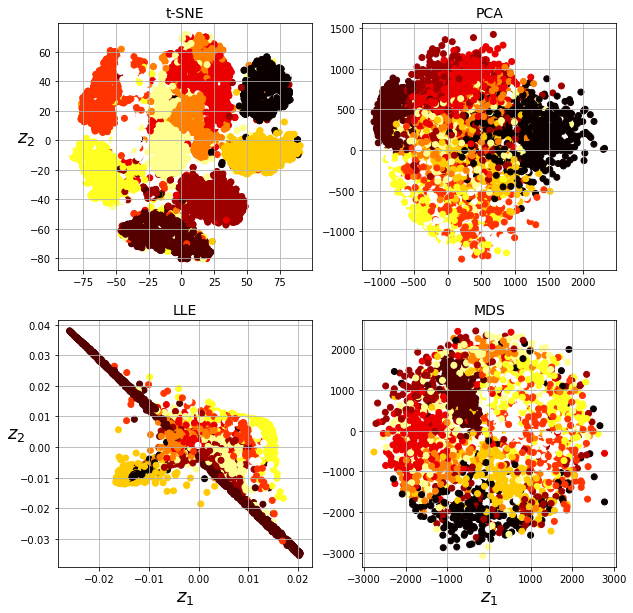

In [43]:
# plot
titles = ["t-SNE", "PCA", "LLE", "MDS"]

plt.figure(figsize=(10,10))

for subplot, title, X_reduced in zip((221, 222, 223, 224), titles,
 (X_reduced_tsne, X_reduced_pca, X_reduced_lle, X_reduced_mds)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    if subplot == 224:
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_2000, cmap=plt.cm.hot)
    else:
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_10000, cmap=plt.cm.hot)
    if (subplot == 223)|(subplot ==224):
        plt.xlabel("$z_1$", fontsize=18)
    if (subplot == 221)|(subplot == 223):
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
plt.show()